In [78]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_8408\1940832839.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ohlcv_df = pd.read_csv(


,close,volume
date,,
2015-01-21 09:30:00,4.766,120
2015-01-21 11:00:00,4.796,100
2015-01-22 15:00:00,4.884,100
2015-01-22 15:15:00,4.888,200
2015-01-22 15:30:00,4.892,200


In [79]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

In [81]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,4.796,0.006295
2015-01-22 15:00:00,4.884,0.018349
2015-01-22 15:15:00,4.888,0.000819
2015-01-22 15:30:00,4.892,0.000818
2015-01-26 12:30:00,4.866,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,6.654,-0.006866
2021-01-22 11:30:00,6.670,0.002405
2021-01-22 13:45:00,6.684,0.002099
2021-01-22 14:30:00,6.694,0.001496
2021-01-22 15:45:00,6.688,-0.000896


In [84]:
# Set the short window and long window
short_window = 3
long_window = 50

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-02-23 15:30:00,4.892,0.000818,4.889333,4.84400
2015-02-23 15:45:00,4.898,0.001226,4.892667,4.84604
2015-02-24 10:45:00,4.944,0.009392,4.911333,4.84724
2015-02-24 11:00:00,4.948,0.000809,4.930000,4.84844
2015-02-24 12:15:00,4.940,-0.001617,4.944000,4.84940


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,6.654,-0.006866,6.649333,6.24464
2021-01-22 11:30:00,6.670,0.002405,6.674667,6.25696
2021-01-22 13:45:00,6.684,0.002099,6.669333,6.26960
2021-01-22 14:30:00,6.694,0.001496,6.682667,6.28264
2021-01-22 15:45:00,6.688,-0.000896,6.688667,6.29536


In [85]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

C:\Users\HP\AppData\Local\Temp\ipykernel_8408\4011502292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df['Signal'] = 0.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-02-23 15:30:00,4.892,0.000818,4.889333,4.84400,1.0
2015-02-23 15:45:00,4.898,0.001226,4.892667,4.84604,1.0
2015-02-24 10:45:00,4.944,0.009392,4.911333,4.84724,1.0
2015-02-24 11:00:00,4.948,0.000809,4.930000,4.84844,1.0
2015-02-24 12:15:00,4.940,-0.001617,4.944000,4.84940,-1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,6.654,-0.006866,6.649333,6.24464,-1.0
2021-01-22 11:30:00,6.670,0.002405,6.674667,6.25696,1.0
2021-01-22 13:45:00,6.684,0.002099,6.669333,6.26960,1.0
2021-01-22 14:30:00,6.694,0.001496,6.682667,6.28264,1.0
2021-01-22 15:45:00,6.688,-0.000896,6.688667,6.29536,-1.0


In [86]:
signals_df['Signal'].value_counts()

Signal
 1.0    2404
-1.0    1869
Name: count, dtype: int64

In [87]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

C:\Users\HP\AppData\Local\Temp\ipykernel_8408\2718297389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-02-23 15:30:00,4.892,0.000818,4.889333,4.84400,1.0,NaN
2015-02-23 15:45:00,4.898,0.001226,4.892667,4.84604,1.0,0.001226
2015-02-24 10:45:00,4.944,0.009392,4.911333,4.84724,1.0,0.009392
2015-02-24 11:00:00,4.948,0.000809,4.930000,4.84844,1.0,0.000809
2015-02-24 12:15:00,4.940,-0.001617,4.944000,4.84940,-1.0,-0.001617


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,6.654,-0.006866,6.649333,6.24464,-1.0,-0.006866
2021-01-22 11:30:00,6.670,0.002405,6.674667,6.25696,1.0,-0.002405
2021-01-22 13:45:00,6.684,0.002099,6.669333,6.26960,1.0,0.002099
2021-01-22 14:30:00,6.694,0.001496,6.682667,6.28264,1.0,0.001496
2021-01-22 15:45:00,6.688,-0.000896,6.688667,6.29536,-1.0,-0.000896


<Axes: xlabel='date'>

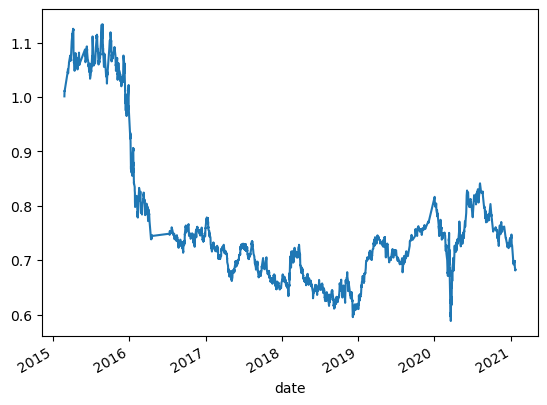

In [88]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [89]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-02-23 15:45:00,4.889333,4.84400
2015-02-24 10:45:00,4.892667,4.84604
2015-02-24 11:00:00,4.911333,4.84724
2015-02-24 12:15:00,4.930000,4.84844
2015-02-24 15:45:00,4.944000,4.84940


In [90]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

Signal
 1.0    2404
-1.0    1869
Name: count, dtype: int64

In [91]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-02-23 15:45:00


In [92]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(weeks=3)

# Display the training end date
print(training_end)

2015-03-16 15:45:00


In [93]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train

,SMA_Fast,SMA_Slow
date,,
2015-02-23 15:45:00,4.889333,4.84400
2015-02-24 10:45:00,4.892667,4.84604
2015-02-24 11:00:00,4.911333,4.84724
2015-02-24 12:15:00,4.930000,4.84844
2015-02-24 15:45:00,4.944000,4.84940
2015-03-11 13:00:00,4.941333,4.85080
2015-03-11 14:45:00,4.879333,4.84892
2015-03-12 15:45:00,4.821333,4.84720
2015-03-13 14:45:00,4.772667,4.84604


In [94]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-02-23 15:45:00,4.889333,4.84400
2015-02-24 10:45:00,4.892667,4.84604
2015-02-24 11:00:00,4.911333,4.84724
2015-02-24 12:15:00,4.930000,4.84844
2015-02-24 15:45:00,4.944000,4.84940


In [95]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)